#Final Project
#Group: Alvin Liu, Luke Sims, Matthew Ayala
#Task - Image Similarity


In [2]:
# [CELL 1] - Setup
# The -q flag keeps it quiet.
import sys
import subprocess

# Helper function to install packages via pip from within the notebook
def install_packages(packages):
    print(f"Installing: {', '.join(packages)}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install"] + packages)
    print("Installation complete.")

# List of all required libraries for the project
required_libraries = [
    "torch",                # Deep learning framework (ViT)
    "torchvision",          # Image transforms
    "transformers",         # Hugging Face ViT model
    "datasets",             # Hugging Face dataset loader
    "opencv-python",        # SIFT algorithm & image processing
    "scikit-learn",         # t-SNE & Cosine Similarity
    "matplotlib",           # Plotting graphs
    "numpy",                # Array manipulation
    "pandas",               # Data handling
    "tqdm",                 # Progress bars
    "ipywidgets"            # Required for progress bars in VS Code
]

# Install everything
try:
    install_packages(required_libraries)
except Exception as e:
    print(f"An error occurred during installation: {e}")
    print("Try running this command in your terminal: pip install " + " ".join(required_libraries))

import torch
import torchvision.transforms as transforms
from datasets import load_dataset
from PIL import Image
import numpy as np
import cv2
from transformers import ViTModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from typing import List, Tuple
import matplotlib.pyplot as plt
import random

# --- FIX: Use standard tqdm instead of tqdm.notebook ---
# This fixes the "IProgress not found" error on local machines
from tqdm import tqdm 

# Set device for PyTorch/ViT computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type != 'cuda':
    print("WARNING: You are running on CPU. This might be slow.")

Installing: torch, torchvision, transformers, datasets, opencv-python, scikit-learn, matplotlib, numpy, pandas, tqdm, ipywidgets...
Installation complete.
Using device: cpu


In [3]:
# [CELL 2] - Data Loading
# Load the Tiny-Imagenet dataset (using the 'validation' split as the test set)
print("Downloading TinyImagenet test split...")
try:
    dataset = load_dataset("slegroux/tiny-imagenet-200-clean", split="validation")
except Exception as e:
    print(f"Error loading dataset: {e}")

# Extract images and map class names to IDs
test_images = []
test_labels = []

unique_classes = sorted(list(set(dataset["label"])))
class_to_idx = {name: i for i, name in enumerate(unique_classes)}

# Convert to RGB to ensure consistency
print("Processing images...")
for item in tqdm(dataset, desc="Loading Data"):
    test_images.append(item["image"].convert("RGB"))
    test_labels.append(class_to_idx[item["label"]])

N_total = len(test_images)
# --- CONFIGURATION ---
# Increase this to 200 or 500 for your final report. 
# 100 is good for a quick test.
subset_size = 150 
print(f"Loaded {N_total} total images. Running evaluation on a subset of {subset_size} images.")

# Define transformation pipeline for ViT
ViT_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

Processing images...


Loading Data: 100%|██████████| 4909/4909 [00:00<00:00, 6516.90it/s]

Loaded 4909 total images. Running evaluation on a subset of 150 images.


In [4]:
# [CELL 3] - ViT Method
# 1. Load ViT model
model_name = 'google/vit-base-patch16-224'
ViT_model = ViTModel.from_pretrained(model_name)
ViT_model.eval()
ViT_model.to(device)

# --- ViT Hyperparameter ---
ViT_SIMILARITY_THRESHOLD = 0.85

# Global cache to store embeddings (Optimization for Colab)
vit_cache = []

def get_vit_embedding(image: Image.Image) -> np.ndarray:
    """Computes the ViT embedding (CLS token output) for an image."""
    input_tensor = ViT_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = ViT_model(input_tensor)
        cls_token_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy().flatten()
    return cls_token_embedding

def vit_similarity_prediction(emb_A: np.ndarray, emb_B: np.ndarray) -> bool:
    similarity_score = cosine_similarity(emb_A.reshape(1, -1), emb_B.reshape(1, -1))[0, 0]
    return similarity_score >= ViT_SIMILARITY_THRESHOLD

def evaluate_pairwise_accuracy_vit(images, labels, subset_n):
    print("--- Evaluating ViT Method ---")
    
    # 1. Pre-compute embeddings
    # We store these in a global variable so the next cell (Tuning) is instant
    global vit_cache
    vit_cache = [] 
    
    print(f"Computing {subset_n} ViT embeddings...")
    for i in tqdm(range(subset_n), desc="ViT Extraction"):
        vit_cache.append(get_vit_embedding(images[i]))

    correct_predictions = 0
    total_predictions = 0
    
    print(f"Testing pairs with threshold {ViT_SIMILARITY_THRESHOLD}...")

    for i in range(subset_n):
        for j in range(subset_n):
            ground_truth_similar = (labels[i] == labels[j]) 
            predicted_similar = vit_similarity_prediction(vit_cache[i], vit_cache[j])
            
            if predicted_similar == ground_truth_similar:
                correct_predictions += 1
            total_predictions += 1

    accuracy = correct_predictions / total_predictions
    print(f"ViT Pairwise Accuracy ({subset_n}x{subset_n}): {accuracy * 100:.2f}%")
    return accuracy

# Execute ViT evaluation
vit_accuracy = evaluate_pairwise_accuracy_vit(test_images, test_labels, subset_size)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Evaluating ViT Method ---
Computing 150 ViT embeddings...


ViT Extraction: 100%|██████████| 150/150 [00:20<00:00,  7.38it/s]


Testing pairs with threshold 0.85...
ViT Pairwise Accuracy (150x150): 85.65%


In [5]:
# [CELL 4] - SIFT Method
# 1. Initialize SIFT Detector
try:
    sift = cv2.SIFT_create()
except AttributeError:
    print("WARNING: SIFT is unavailable. Ensure `opencv-contrib-python` is installed.")
    sift = None

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50) 
flann = cv2.FlannBasedMatcher(index_params, search_params)

# --- SIFT Hyperparameters ---
SIFT_LOWE_RATIO_THRESHOLD = 0.7
SIFT_MIN_MATCHES_THRESHOLD = 10

# Global cache for SIFT features
sift_cache = []

def get_sift_features(image: Image.Image):
    if sift is None: return None, None
    img_cv = np.array(image.convert("L")) 
    keypoints, descriptors = sift.detectAndCompute(img_cv, None)
    return keypoints, descriptors

def sift_similarity_prediction(desc_A, desc_B) -> bool:
    if desc_A is None or desc_B is None or len(desc_A) < 2 or len(desc_B) < 2:
        return False 
    matches = flann.knnMatch(desc_A.astype(np.float32), desc_B.astype(np.float32), k=2)
    good_matches = []
    for pair in matches:
        if len(pair) == 2:
            m, n = pair
            if m.distance < SIFT_LOWE_RATIO_THRESHOLD * n.distance:
                good_matches.append(m)
    return len(good_matches) >= SIFT_MIN_MATCHES_THRESHOLD

def evaluate_pairwise_accuracy_sift(images, labels, subset_n):
    if sift is None: return 0
    print("--- Evaluating SIFT Method ---")
    
    # 1. Pre-extract features
    global sift_cache
    sift_cache = []
    
    print(f"Pre-extracting SIFT features for {subset_n} images...")
    for i in tqdm(range(subset_n), desc="SIFT Extraction"):
        sift_cache.append(get_sift_features(images[i]))

    correct_predictions = 0
    total_predictions = 0
    
    print(f"Testing pairs (Min Matches: {SIFT_MIN_MATCHES_THRESHOLD})...")

    for i in range(subset_n):
        _, desc_i = sift_cache[i]
        if desc_i is None or len(desc_i) < 2: 
            # If we can't extract features, we assume they aren't similar (False)
            # We still need to count this prediction
            for j in range(subset_n):
                if (labels[i] == labels[j]) == False: correct_predictions += 1
                total_predictions += 1
            continue

        for j in range(subset_n):
            _, desc_j = sift_cache[j]
            ground_truth_similar = (labels[i] == labels[j]) 
            
            # Only match if both have descriptors
            if desc_j is None or len(desc_j) < 2:
                predicted_similar = False
            else:
                predicted_similar = sift_similarity_prediction(desc_i, desc_j)
            
            if predicted_similar == ground_truth_similar:
                correct_predictions += 1
            total_predictions += 1
    
    accuracy = correct_predictions / total_predictions
    print(f"SIFT Pairwise Accuracy ({subset_n}x{subset_n}): {accuracy * 100:.2f}%")
    return accuracy

# Execute SIFT evaluation
sift_accuracy = evaluate_pairwise_accuracy_sift(test_images, test_labels, subset_size)

--- Evaluating SIFT Method ---
Pre-extracting SIFT features for 150 images...


SIFT Extraction: 100%|██████████| 150/150 [00:00<00:00, 659.17it/s]


Testing pairs (Min Matches: 10)...
SIFT Pairwise Accuracy (150x150): 84.20%


Starting ViT Threshold Sweep (Using Cache)...
Threshold 0.30: Accuracy 86.72%
Threshold 0.40: Accuracy 91.02%
Threshold 0.50: Accuracy 90.95%
Threshold 0.60: Accuracy 89.89%
Threshold 0.70: Accuracy 88.33%
Threshold 0.75: Accuracy 87.47%
Threshold 0.80: Accuracy 86.67%
Threshold 0.85: Accuracy 85.65%
Threshold 0.90: Accuracy 84.58%
Threshold 0.95: Accuracy 84.21%
Starting SIFT Match Count Sweep (Using Cache)...
Min Matches 2: Accuracy 83.62%
Min Matches 5: Accuracy 84.19%
Min Matches 7.5: Accuracy 84.20%
Min Matches 10: Accuracy 84.20%
Min Matches 12.5: Accuracy 84.19%
Min Matches 15: Accuracy 84.18%
Min Matches 20: Accuracy 84.15%
Min Matches 25: Accuracy 84.10%
Min Matches 30: Accuracy 84.05%


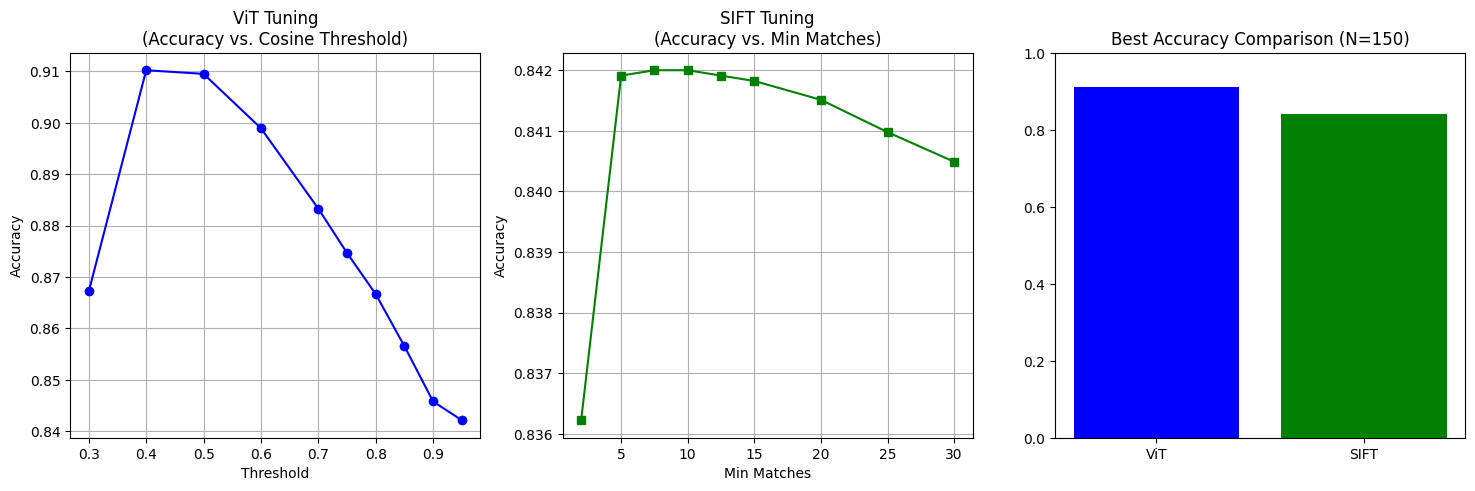

In [6]:
# [CELL 5] - Tuning & Graphs
import matplotlib.pyplot as plt

def run_vit_tuning(labels, subset_n, thresholds):
    """Sweeps through thresholds using cached embeddings."""
    accuracies = []
    print("Starting ViT Threshold Sweep (Using Cache)...")
    
    # Ensure cache exists
    if len(vit_cache) < subset_n:
        print("Error: ViT cache is empty or smaller than subset. Run Cell 3 first.")
        return []

    for thresh in thresholds:
        correct = 0
        total = 0
        for i in range(subset_n):
            for j in range(subset_n):
                ground_truth = (labels[i] == labels[j])
                # Calculate score using CACHED embeddings
                score = cosine_similarity(vit_cache[i].reshape(1, -1), vit_cache[j].reshape(1, -1))[0, 0]
                prediction = score >= thresh
                
                if prediction == ground_truth:
                    correct += 1
                total += 1
        acc = correct / total
        accuracies.append(acc)
        print(f"Threshold {thresh:.2f}: Accuracy {acc*100:.2f}%")
    return accuracies

def run_sift_tuning(labels, subset_n, match_thresholds):
    """Sweeps through match counts using cached features."""
    accuracies = []
    print("Starting SIFT Match Count Sweep (Using Cache)...")
    
    if len(sift_cache) < subset_n:
        print("Error: SIFT cache is empty. Run Cell 4 first.")
        return []

    for min_matches in match_thresholds:
        correct = 0
        total = 0
        for i in range(subset_n):
            _, desc_i = sift_cache[i]
            if desc_i is None or len(desc_i) < 2:
                # Fallback if feature extraction failed for image i
                for j in range(subset_n):
                    if (labels[i] == labels[j]) == False: correct += 1
                    total += 1
                continue
                
            for j in range(subset_n):
                _, desc_j = sift_cache[j]
                ground_truth = (labels[i] == labels[j])
                
                # Manual prediction logic to allow changing the threshold variable
                if desc_j is None or len(desc_j) < 2:
                    prediction = False
                else:
                    matches = flann.knnMatch(desc_i.astype(np.float32), desc_j.astype(np.float32), k=2)
                    good_count = 0
                    for pair in matches:
                        if len(pair) == 2:
                            m, n = pair
                            if m.distance < 0.7 * n.distance: # Fixed Ratio Test
                                good_count += 1
                    prediction = good_count >= min_matches
                
                if prediction == ground_truth:
                    correct += 1
                total += 1
        
        acc = correct / total
        accuracies.append(acc)
        print(f"Min Matches {min_matches}: Accuracy {acc*100:.2f}%")
    return accuracies

# --- Run the Tuning ---
vit_thresholds = [0.30, 0.40, 0.50, 0.60, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
sift_matches = [2, 5, 7.5, 10, 12.5, 15, 20, 25, 30]

vit_results = run_vit_tuning(test_labels, subset_size, vit_thresholds)
sift_results = run_sift_tuning(test_labels, subset_size, sift_matches)

# --- Plotting ---
plt.figure(figsize=(18, 5))

# 1. ViT Plot
plt.subplot(1, 3, 1)
plt.plot(vit_thresholds, vit_results, marker='o', color='b')
plt.title("ViT Tuning\n(Accuracy vs. Cosine Threshold)")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.grid(True)

# 2. SIFT Plot
plt.subplot(1, 3, 2)
plt.plot(sift_matches, sift_results, marker='s', color='g')
plt.title("SIFT Tuning\n(Accuracy vs. Min Matches)")
plt.xlabel("Min Matches")
plt.ylabel("Accuracy")
plt.grid(True)

# 3. Bar Comparison
plt.subplot(1, 3, 3)
methods = ['ViT', 'SIFT']
# Handle empty results if code failed
best_vit = max(vit_results) if vit_results else 0
best_sift = max(sift_results) if sift_results else 0
plt.bar(methods, [best_vit, best_sift], color=['blue', 'green'])
plt.title(f"Best Accuracy Comparison (N={subset_size})")
plt.ylim(0, 1.0)
plt.show()

Generating ViT t-SNE visualization...


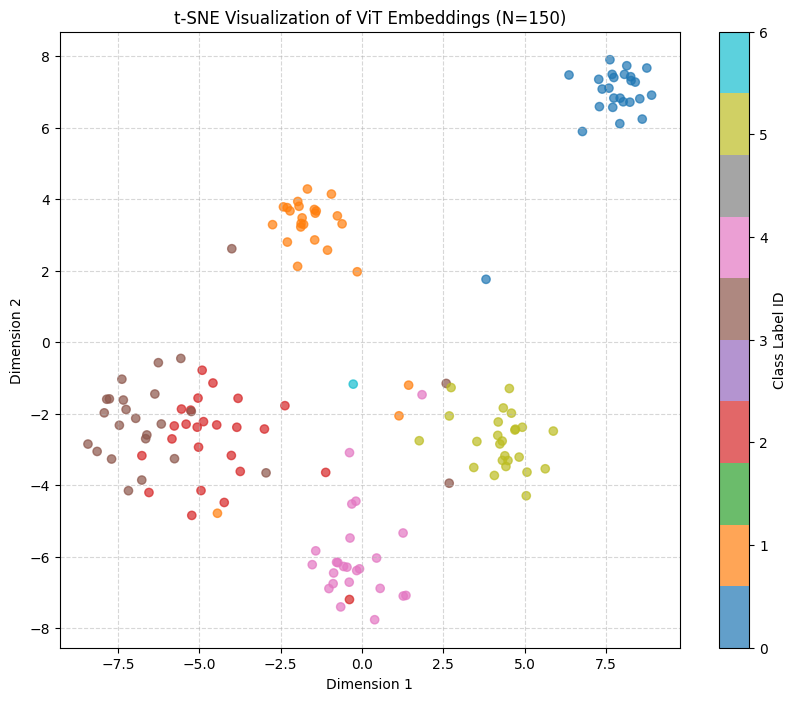

Searching for 3 different high-quality SIFT pairs...
Found pair (Indices 0, 1) with 7 matches.


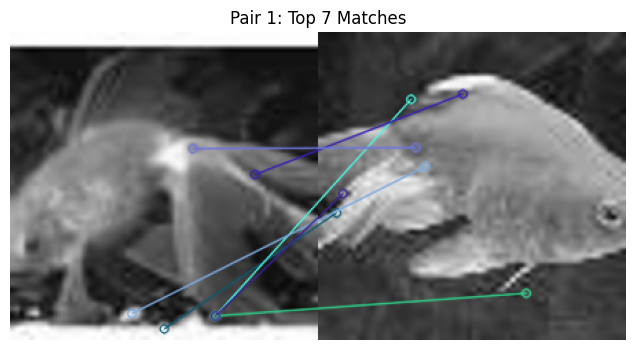

Found pair (Indices 0, 2) with 5 matches.


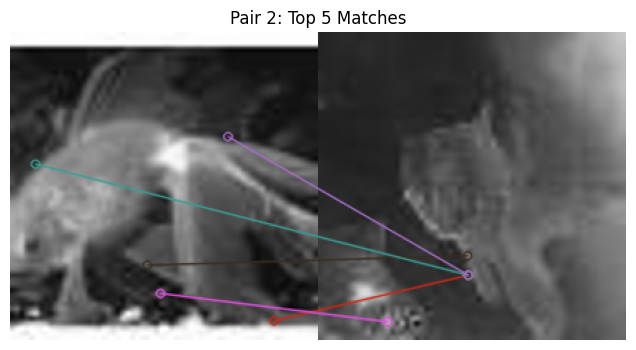

Found pair (Indices 0, 6) with 6 matches.


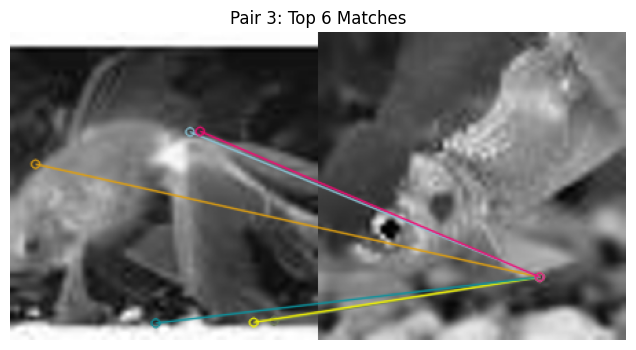

In [8]:
# [CELL 6] - Visual Analysis (Updated for Multiple Pairs)
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- A. ViT Embedding Visualization (t-SNE) ---
def plot_vit_tsne(labels, subset_n):
    print("Generating ViT t-SNE visualization...")
    
    if 'vit_cache' not in globals() or not vit_cache:
        print("Error: 'vit_cache' is empty. Please RUN CELL 3 first.")
        return

    embeddings_np = np.array(vit_cache[:subset_n])
    perp = min(30, subset_n - 1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perp)
    embeddings_2d = tsne.fit_transform(embeddings_np)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels[:subset_n], cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label="Class Label ID")
    plt.title(f"t-SNE Visualization of ViT Embeddings (N={subset_n})")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# --- B. SIFT Multiple Match Visualization ---
def visualize_multiple_sift_matches(images, labels, subset_n, num_pairs_to_show=3):
    print(f"Searching for {num_pairs_to_show} different high-quality SIFT pairs...")
    
    shown_count = 0
    search_limit = 500 # Don't search forever
    checks = 0

    for i in range(subset_n):
        for j in range(i+1, subset_n):
            if labels[i] == labels[j]: # Only check same-class pairs
                
                # Upscale for better feature detection
                img_a_large = images[i].resize((224, 224), Image.BICUBIC)
                img_b_large = images[j].resize((224, 224), Image.BICUBIC)
                
                # Convert to CV2 format
                gray_a = cv2.cvtColor(np.array(img_a_large), cv2.COLOR_RGB2GRAY)
                gray_b = cv2.cvtColor(np.array(img_b_large), cv2.COLOR_RGB2GRAY)

                # Detect
                kp_a, desc_a = sift.detectAndCompute(gray_a, None)
                kp_b, desc_b = sift.detectAndCompute(gray_b, None)
                
                if desc_a is not None and desc_b is not None and len(desc_a) > 1 and len(desc_b) > 1:
                    matches = flann.knnMatch(desc_a.astype(np.float32), desc_b.astype(np.float32), k=2)
                    
                    good = []
                    for pair in matches:
                        if len(pair) == 2:
                            m, n = pair
                            # Slightly relaxed ratio for visualization purposes
                            if m.distance < 0.8 * n.distance:
                                good.append(m)
                    
                    # If we found a decent number of matches, show it!
                    if len(good) >= 4:
                        print(f"Found pair (Indices {i}, {j}) with {len(good)} matches.")
                        
                        # Sort and pick top 10 matches to keep image clean
                        good = sorted(good, key=lambda x: x.distance)[:10]

                        img_matches = cv2.drawMatches(
                            gray_a, kp_a, 
                            gray_b, kp_b, 
                            good, None, 
                            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                        )
                        
                        plt.figure(figsize=(12, 4))
                        plt.imshow(img_matches)
                        plt.title(f"Pair {shown_count+1}: Top {len(good)} Matches")
                        plt.axis('off')
                        plt.show()
                        
                        shown_count += 1
                        if shown_count >= num_pairs_to_show:
                            return

            checks += 1
            if checks > search_limit: break
        if shown_count >= num_pairs_to_show: break
    
    if shown_count == 0:
        print("Could not find pairs with enough matches to visualize.")

# Execute Visualizations
if 'subset_size' not in globals(): subset_size = 150
plot_vit_tsne(test_labels, subset_n=subset_size)

# Show 3 examples
visualize_multiple_sift_matches(test_images, test_labels, subset_n=subset_size, num_pairs_to_show=3)

#Citations
Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94

https://arxiv.org/abs/2010.11929